In [1]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.corpora import Dictionary

from growing_instability_lib import *

Using TensorFlow backend.


In [2]:
wvmodel = Word2Vec.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.w2v.model')

In [3]:
sample_sub = pd.read_csv('../data/sampleSubmission.csv')
topics = sorted(set(sample_sub.columns.difference(['id'])))

topic2actual = {}
for i in sample_sub.columns:
    if 'id' == i:
        continue
    topic2actual[i] = segment(i)
    
target_columns = sorted(topics)
len(topics)

160

In [4]:
# %%time
# word2idx_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'word2idx_trainingX')
_word2idx = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', '_word2idx')
# trainingY = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'trainingY')

# indices = pd.Index(sorted(trainingY.index[trainingY.index.str.contains('^201[2-4]')]))

# word2idx_trainingX = word2idx_trainingX.ix[indices]
# trainingY = trainingY.ix[indices]

# word2idx_trainingX.to_hdf('training_data_word_index_2012-2014.hdf', 'word2idx_trainingX')
# trainingY.to_hdf('training_data_word_index_2012-2014.hdf', 'trainingY')

word2idx_trainingX = pd.read_hdf('training_data_word_index_2012-2014.hdf', 'word2idx_trainingX')
trainingY = pd.read_hdf('training_data_word_index_2012-2014.hdf', 'trainingY')

In [5]:
train_test_df = pd.read_hdf('train_test_df_3.hdf', 'train_test_df')

In [6]:
def transform_topics(df, topics):
    topics = sorted(topics)
#     v = np.zeros(shape=(df.shape[0], len(topics)))
    v = []
    for ix, tp in enumerate(df.topics):
        tt = []
        for t in tp:
            tt.append(topics.index(t))
#             v[ix][topics.index(t)] = 1
        v.append(tt)

    return pd.Series(v, index=df.index)

In [7]:
ind2word = {j:i for i, j in _word2idx.iteritems()}
ind2class = dict(enumerate(topics))
class2ind = {j: i for i, j in ind2class.items()}

In [8]:
def process_vector(term_vecs, vector_size, mean_window=5, sequence_length=200):
    # 85 percentile length of docs is (198 * 5)

    q = np.arange(0, len(term_vecs), mean_window)
    
    sequence = np.zeros([1, sequence_length, vector_size])
    
    for ix, inds in  enumerate(zip(q, q + mean_window)):
        if ix < sequence_length:
            sequence[0][ix] = np.mean(term_vecs[inds[0]: inds[1]], axis=0)
        else:
            break

    return sequence


def process_ind2word(term_idx):
    return [ind2word.get(idx, -1) for idx in term_idx]

In [9]:
word2idx_trainingX.map(len).quantile(0.8) / 5

197.4

In [10]:
def transform_mean_average(term_idx, stopwords=[], stack=True):
    ret = term_idx.map(process_ind2word).map(
        lambda x: [wvmodel[i] for i in x if i in wvmodel.wv.vocab]
    ).map(
        lambda x: process_vector(x, wvmodel.vector_size)
    )
    
    if stack:
        ret = np.vstack(ret)
        
    return ret


def parallel_generate_word_vectors(samp, transformer, stopwords, batch, num_proc):
    with Parallel(n_jobs=num_proc) as parallel:
        dataset = np.zeros([samp.shape[0], 200, 300])
        is_break = False
        i = 0

        while not is_break:
            payload = []

            for j in xrange(num_proc):
                t_df = samp[(i + j) * batch: (i + 1 + j) * batch]

                if t_df.empty:
                    is_break = True
                    continue

                payload.append(
                    delayed(transformer)(
                        t_df, stopwords
                    )
                )

            print('Current batch in main thread: {}'.format((i + j) * batch))

            if payload:
                results = parallel(payload)
                dataset.extend(results)
                i += num_proc

    return np.vstack(dataset)

In [13]:
train_test_word_indices = transform_text(train_test_df).map(lambda x: [_word2idx.get(i) for i in x.split()])

In [14]:
%%time
x_train = np.zeros(
    [word2idx_trainingX.shape[0] + train_test_word_indices.shape[0], 200, 300], dtype=np.float32
)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 314 µs


In [16]:
%%time
i = 0

for ix, chunk in enumerate(np.array_split(pd.concat([word2idx_trainingX, train_test_word_indices]), 50)):
    chunk = transform_mean_average(chunk)
    j = i + chunk.shape[0]
    x_train[i: j] = chunk
    print ix, i, j

    i = j    

0 0 1140
1 1140 2280
2 2280 3420
3 3420 4560
4 4560 5700
5 5700 6840
6 6840 7980
7 7980 9120
8 9120 10260
9 10260 11400
10 11400 12540
11 12540 13680
12 13680 14820
13 14820 15960
14 15960 17100
15 17100 18240
16 18240 19380
17 19380 20520
18 20520 21660
19 21660 22800
20 22800 23940
21 23940 25080
22 25080 26220
23 26220 27360
24 27360 28500
25 28500 29640
26 29640 30780
27 30780 31920
28 31920 33060
29 33060 34200
30 34200 35340
31 35340 36480
32 36480 37620
33 37620 38760
34 38760 39900
35 39900 41040
36 41040 42180
37 42180 43320
38 43320 44460
39 44460 45600
40 45600 46740
41 46740 47880
42 47880 49020
43 49020 50160
44 50160 51300
45 51300 52440
46 52440 53580
47 53580 54720
48 54720 55860
49 55860 56999
CPU times: user 2min 33s, sys: 13.3 s, total: 2min 47s
Wall time: 2min 36s


In [18]:
200 * 60000 * 300 * 8. / 1000000000

28.8

In [19]:
def build_target(y, size):
    e = np.zeros(size)
    e[y] = 1
    return e

In [20]:
# %%time
# # 6853
# # 3110
# x_dump = parallel_generate_word_vectors(
#     pd.concat([word2idx_trainingX, train_test_word_indices]),
#     transform_mean_average,
#     stopwords=[],
#     batch=1000,
#     num_proc=5
# )

In [21]:
%%time
num_samples = x_train.shape[0]

training_Y = pd.DataFrame(zip(*np.where(trainingY.head(num_samples) == 1)), columns=['iloc', 'topics'])
training_Y = training_Y.groupby('iloc')['topics'].apply(list)
training_Y.index = trainingY.head(num_samples).index

train_test_y = transform_topics(train_test_df, topics)
y_train = pd.concat([training_Y, train_test_y])
y_train = np.vstack(y_train.map(lambda x: build_target(x, len(topics))))

CPU times: user 2.08 s, sys: 12 ms, total: 2.09 s
Wall time: 2.07 s


In [22]:
y_train.shape, x_train.shape

((56999, 160), (56999, 200, 300))

In [23]:
import tensorflow as K
import keras.backend as KB


def f1_micro(y_true, y_pred):
    TP = K.metrics.true_positives(y_true, K.round(y_pred))
    FP = K.metrics.false_positives(y_true, K.round(y_pred))
    FN = K.metrics.false_negatives(y_true, K.round(y_pred))
    
    p = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FP))
    r = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FN))
    
    return (2.0 * p * r) / (p + r)


def f1_score(y_true, y_pred):
    # http://stackoverflow.com/questions/43345909/when-using-mectrics-in-model-compile-in-keras-report-valueerror-unknown-metr
    # Count positive samples.
    c1 = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
    c2 = KB.sum(KB.round(KB.clip(y_pred, 0, 1)))
    c3 = KB.sum(KB.round(KB.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [42]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Convolution1D, MaxPooling1D, Flatten  # , TimeDistributedDense
from keras.models import Model
import itertools as it


ma_input = Input(shape=(None, 300), name='ma_input')

ma_x = LSTM(64, return_sequences=True)(ma_input)
ma_x = LSTM(64, go_backwards=True)(ma_x)
# We stack a deep densely-connected network on top

x = Dense(128, activation='relu')(ma_x)
x = Dropout(0.1)(x)

# And finally we add the main logistic regression layer
main_output = Dense(len(class2ind), activation='sigmoid', name='main_output')(x)

model = Model(
    inputs=[
        ma_input,
    ],
    outputs=[main_output]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ma_input (InputLayer)        (None, None, 300)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          93440     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
main_output (Dense)          (None, 160)               20640     
Total params: 155,424
Trainable params: 155,424
Non-trainable params: 0
_________________________________________________________________


In [130]:
optimizer = keras.optimizers.RMSprop(lr=0.005)
model.compile(
    optimizer=optimizer,  # keras.optimizers.RMSprop(lr=0.005),  # , rho=0.9, epsilon=1e-08, decay=0.0, clipnorm=1),
    loss={'main_output': 'categorical_crossentropy'},
    loss_weights={'main_output': 1.},
    metrics=['accuracy', f1_micro]
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ma_input (InputLayer)        (None, None, 300)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          93440     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
main_output (Dense)          (None, 160)               20640     
Total params: 155,424
Trainable params: 155,424
Non-trainable params: 0
_________________________________________________________________


In [24]:
y_train.shape

(56999, 160)

In [54]:
def generate_batch_train_data(x, y, batch_size=1000, shuffle=True):
    s = x.shape[0]
    q = np.arange(0, s, batch_size)
    indices = zip(q, q + batch_size)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for i, j in indices:
            _y = y[i: j]
            _x = x[i: j]
            if _y.shape[0] > 0:
#                 print('hello')
                yield (np.vstack(_x), _y)

In [32]:
batch_size = 2000
epochs = 10
# steps_per_epoch = (x_dump.shape[0] + batch_size) / batch_size

# train_data_generator = generate_batch_train_data(x_dump, y_train, batch_size=batch_size, shuffle=True)

In [26]:
# %%time
# model.fit_generator(
#     train_data_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     workers=1,
# )

In [62]:
base_file_name = "bidirectional-lstm-weights"
filepath = base_file_name + ".{epoch:02d}-{loss:.4f}-{acc:.4f}-{f1_micro:.4f}.hdf5"
filename = base_file_name + ".log"

model_check_point = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='f1_micro', verbose=0,
    save_best_only=True, save_weights_only=False,
    mode='max', period=1,
)

remote_monitor = keras.callbacks.RemoteMonitor(
    root='http://localhost:9000',
    path='/publish/epoch/end/',
    field='data', headers=None
)

csv_logger = keras.callbacks.CSVLogger(filename=filename, separator=',', append=False)

callbacks = [model_check_point, remote_monitor, csv_logger]

In [138]:
%%time
batch_size = 2000
epochs = 10
hist = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/10
56999/56999 [==============================] - 30s - loss: 2.0243 - acc: 0.6434 - f1_micro: 0.5626    
Epoch 2/10
56999/56999 [==============================] - 31s - loss: 1.9847 - acc: 0.6492 - f1_micro: 0.5636    
Epoch 3/10
56999/56999 [==============================] - 31s - loss: 1.9596 - acc: 0.6498 - f1_micro: 0.5647    
Epoch 4/10
56999/56999 [==============================] - 31s - loss: 1.9675 - acc: 0.6506 - f1_micro: 0.5659    
Epoch 5/10
56999/56999 [==============================] - 31s - loss: 1.9278 - acc: 0.6550 - f1_micro: 0.5671    
Epoch 6/10
56999/56999 [==============================] - 31s - loss: 1.9032 - acc: 0.6580 - f1_micro: 0.5684    
Epoch 7/10
56999/56999 [==============================] - 31s - loss: 1.9099 - acc: 0.6555 - f1_micro: 0.5700    
Epoch 8/10
56999/56999 [==============================] - 31s - loss: 1.8922 - acc: 0.6594 - f1_micro: 0.5716    
Epoch 9/10
56999/56999 [==============================] - 31s - loss: 1.8598 - acc: 0.66

In [145]:
%%time
batch_size = 2000
epochs = 50
hist = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
56999/56999 [==============================] - 30s - loss: 1.4119 - acc: 0.7233 - f1_micro: 0.6582    
Epoch 2/50
56999/56999 [==============================] - 30s - loss: 1.4072 - acc: 0.7240 - f1_micro: 0.6595    
Epoch 3/50
56999/56999 [==============================] - 30s - loss: 1.3998 - acc: 0.7284 - f1_micro: 0.6607    
Epoch 4/50
56999/56999 [==============================] - 30s - loss: 1.3913 - acc: 0.7279 - f1_micro: 0.6620    
Epoch 5/50
56999/56999 [==============================] - 30s - loss: 1.4040 - acc: 0.7260 - f1_micro: 0.6632    
Epoch 6/50
56999/56999 [==============================] - 30s - loss: 1.3816 - acc: 0.7282 - f1_micro: 0.6644    
Epoch 7/50
56999/56999 [==============================] - 30s - loss: 1.3949 - acc: 0.7270 - f1_micro: 0.6656    
Epoch 8/50
56999/56999 [==============================] - 30s - loss: 1.3718 - acc: 0.7304 - f1_micro: 0.6669    
Epoch 9/50
56999/56999 [==============================] - 30s - loss: 1.3791 - acc: 0.73

In [157]:
%%time
batch_size = 2000
epochs = 50
hist = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
56999/56999 [==============================] - 30s - loss: 1.2418 - acc: 0.7488 - f1_micro: 0.7095    
Epoch 2/50
56999/56999 [==============================] - 30s - loss: 1.2268 - acc: 0.7505 - f1_micro: 0.7104    
Epoch 3/50
56999/56999 [==============================] - 30s - loss: 1.2447 - acc: 0.7463 - f1_micro: 0.7112    
Epoch 4/50
56999/56999 [==============================] - 31s - loss: 1.2283 - acc: 0.7492 - f1_micro: 0.7120    
Epoch 5/50
56999/56999 [==============================] - 30s - loss: 1.2246 - acc: 0.7514 - f1_micro: 0.7129    
Epoch 6/50
56999/56999 [==============================] - 30s - loss: 1.2284 - acc: 0.7544 - f1_micro: 0.7137    
Epoch 7/50
56999/56999 [==============================] - 30s - loss: 1.2160 - acc: 0.7513 - f1_micro: 0.7145    
Epoch 8/50
56999/56999 [==============================] - 31s - loss: 1.2272 - acc: 0.7507 - f1_micro: 0.7153    
Epoch 9/50
56999/56999 [==============================] - 30s - loss: 1.2294 - acc: 0.75

In [270]:
%%time
batch_size = 2000
epochs = 1
hist = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/1
56999/56999 [==============================] - 30s - loss: 1.1229 - acc: 0.7629 - f1_micro: 0.7580    
CPU times: user 28.4 s, sys: 8.23 s, total: 36.6 s
Wall time: 30.9 s


In [67]:
from sklearn.metrics import f1_score as sk_f1_score


In [271]:
g = model.predict(
    x_train,
    batch_size=batch_size
)

In [272]:
%%time
dt = 0.01
s = 0.0
e = 0.5
th = np.arange(s, e + dt, dt)
mean_fscores = []
for t in th:
    %time mean_fscores.append((t, sk_f1_score(y_train, 1.0 * (g > t), average='micro')))
    print t, mean_fscores[-1]

CPU times: user 828 ms, sys: 76 ms, total: 904 ms
Wall time: 899 ms
0.0 (0.0, 0.022062077184089271)
CPU times: user 436 ms, sys: 4 ms, total: 440 ms
Wall time: 436 ms
0.01 (0.01, 0.69617091085343574)
CPU times: user 420 ms, sys: 16 ms, total: 436 ms
Wall time: 435 ms
0.02 (0.02, 0.73783209351753443)
CPU times: user 424 ms, sys: 8 ms, total: 432 ms
Wall time: 432 ms
0.03 (0.029999999999999999, 0.7613669286413951)
CPU times: user 412 ms, sys: 20 ms, total: 432 ms
Wall time: 433 ms
0.04 (0.040000000000000001, 0.77678074371821371)
CPU times: user 428 ms, sys: 12 ms, total: 440 ms
Wall time: 434 ms
0.05 (0.050000000000000003, 0.78848134281671978)
CPU times: user 424 ms, sys: 16 ms, total: 440 ms
Wall time: 438 ms
0.06 (0.059999999999999998, 0.79746105020196201)
CPU times: user 432 ms, sys: 12 ms, total: 444 ms
Wall time: 440 ms
0.07 (0.070000000000000007, 0.80468773237886559)
CPU times: user 436 ms, sys: 8 ms, total: 444 ms
Wall time: 441 ms
0.08 (0.080000000000000002, 0.81097245846692656)


In [281]:
thresh, thresh_score = sorted(mean_fscores, key=lambda x: x[1], reverse=True)[0]
thresh, thresh_score

(0.29999999999999999, 0.84778995024480464)

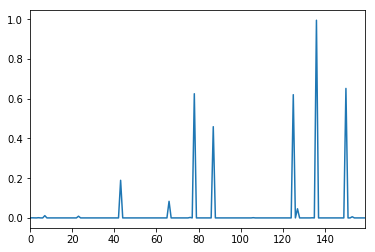

In [274]:
%matplotlib inline
ix = 15
sd = -0
pd.Series(g[sd:][ix]).plot()

In [275]:
# thresh = 0.5
np.where(y_train[sd:][ix] == 1), np.where(g[sd:][ix] > thresh)

((array([ 78,  87, 125, 136, 150]),), (array([ 78,  87, 125, 136, 150]),))

In [184]:
topics[136]

'syria'

In [74]:
def get_classes(pred, scale_param=0.75, min_thresh=0.05, thresh = 0.5):
#     mx = pred.mean() + 3 * pred.std()
    return np.where(pred > thresh)[0]  

In [75]:
with open('../data/TestData.json') as fl:
    data = json.load(fl)
    test_df = pd.DataFrame(data['TestData']).T
    del(data)

In [76]:
test_word_indices = transform_text(test_df).map(lambda x: [_word2idx.get(i) for i in x.split()])

In [92]:
# test_null_index = test_word_indices[test_word_indices.map(len) == 0].index

In [82]:
%%time
x_test = np.zeros(
    [test_word_indices.shape[0], 200, 300], dtype=np.float32
)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 31.9 µs


In [83]:
%%time
ii = 0

for ix, chunk in enumerate(np.array_split(test_word_indices, 50)):
    chunk = transform_mean_average(chunk)
    jj = ii + chunk.shape[0]
    x_test[ii: jj] = chunk
    print ix, ii, jj

    ii = jj

0 0 152
1 152 304
2 304 456
3 456 608
4 608 760
5 760 912
6 912 1064
7 1064 1216
8 1216 1368
9 1368 1520
10 1520 1672
11 1672 1824
12 1824 1976
13 1976 2128
14 2128 2280
15 2280 2432
16 2432 2584
17 2584 2736
18 2736 2888
19 2888 3040
20 3040 3192
21 3192 3344
22 3344 3496
23 3496 3648
24 3648 3800
25 3800 3952
26 3952 4104
27 4104 4256
28 4256 4408
29 4408 4560
30 4560 4712
31 4712 4863
32 4863 5014
33 5014 5165
34 5165 5316
35 5316 5467
36 5467 5618
37 5618 5769
38 5769 5920
39 5920 6071
40 6071 6222
41 6222 6373
42 6373 6524
43 6524 6675
44 6675 6826
45 6826 6977
46 6977 7128
47 7128 7279
48 7279 7430
49 7430 7581
CPU times: user 23.7 s, sys: 2.02 s, total: 25.8 s
Wall time: 23 s


In [285]:
test_probas = model.predict(x_test, batch_size=batch_size)

In [289]:
# %%time
# valid_test_feature_vec found below!
thresh = 0.4
# pos_count = []
# dt = 0.01
# for thresh in  np.arange(0, 0.5 + dt, dt):
test_values = np.zeros([test_probas.shape[0], len(topics)])
for ix, pred in enumerate(test_probas):
    for v in get_classes(pred, thresh=thresh):
        test_values[ix][v] = 1

test_sub_df = pd.DataFrame(
    test_values,
    index=test_df.index,
    columns=topics
)

test_sub_df = test_sub_df.sort_index()
a = test_sub_df.sum(axis=0).sum()
#     pos_count.append((thresh, a))

In [279]:
pos_count = pd.DataFrame(pos_count, columns=['thresh', 'counts'])

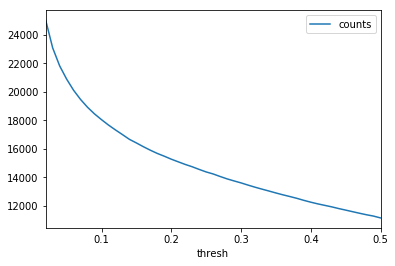

In [267]:
pos_count[pos_count.thresh > 0.01].plot(x='thresh', y='counts')

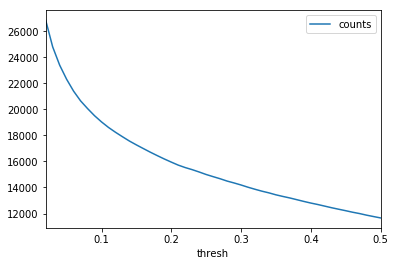

In [280]:
pos_count[pos_count.thresh > 0.01].plot(x='thresh', y='counts')

In [290]:
a

12806.0

In [256]:
hist.history['loss'][-1]

1.1366796678015114

In [291]:
sub_filename = 'bidirectional-lstm-mean_averaged_window-loss_{:.4f}-f1_micro_{:.4f}-thresh_{}.csv'.format(hist.history['loss'][-1], hist.history['f1_micro'][-1], thresh)
print sub_filename

bidirectional-lstm-mean_averaged_window-loss_1.1229-f1_micro_0.7580-thresh_0.4.csv


In [292]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    sub_filename, 
    index=False
)

In [268]:
test_sub_df.sum().describe()

count     160.00000
mean       69.68125
std       154.89779
min         0.00000
25%         4.00000
50%        16.50000
75%        59.25000
max      1390.00000
dtype: float64

In [229]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               173.0
aid                                        89.0
algerianhostagecrisis                      19.0
alqaida                                   177.0
alshabaab                                  40.0
antiwar                                     0.0
arabandmiddleeastprotests                 434.0
armstrade                                 107.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      42.0
bastilledaytruckattack                     15.0
belgium                                    24.0
berlinchristmasmarketattack                10.0
bigdata                                     1.0
biometrics                                  0.0
bokoharam                                  41.0
bostonmarathonbombing                      52.0
britisharmy                                15.0
brusselsattacks                            34.0
cameroon                                

In [284]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               147.0
aid                                       127.0
algerianhostagecrisis                      34.0
alqaida                                   246.0
alshabaab                                  46.0
antiwar                                     0.0
arabandmiddleeastprotests                 376.0
armstrade                                  78.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      64.0
bastilledaytruckattack                      9.0
belgium                                    12.0
berlinchristmasmarketattack                12.0
bigdata                                     3.0
biometrics                                  0.0
bokoharam                                  65.0
bostonmarathonbombing                      77.0
britisharmy                                12.0
brusselsattacks                            41.0
cameroon                                